In [421]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
import warnings
warnings.filterwarnings('ignore')

In [422]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [423]:
print("The train dataset has %d observations and %d features" % train.shape)
print("The test dataset has %d observations and %d features" % test.shape)
cat_features = train.select_dtypes(include=["object"]).columns
num_features = train.select_dtypes(exclude=['object']).columns
print("# of Numerical features is " + str(len(num_features)) + " and # of categorical features is " + str(len(cat_features)))

The train dataset has 1460 observations and 81 features
The test dataset has 1459 observations and 80 features
# of Numerical features is 38 and # of categorical features is 43


In [424]:
# Check the label: Average sale price is 181k, with the highest value of 755k and the lowest value of 79k
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Check out numeric features

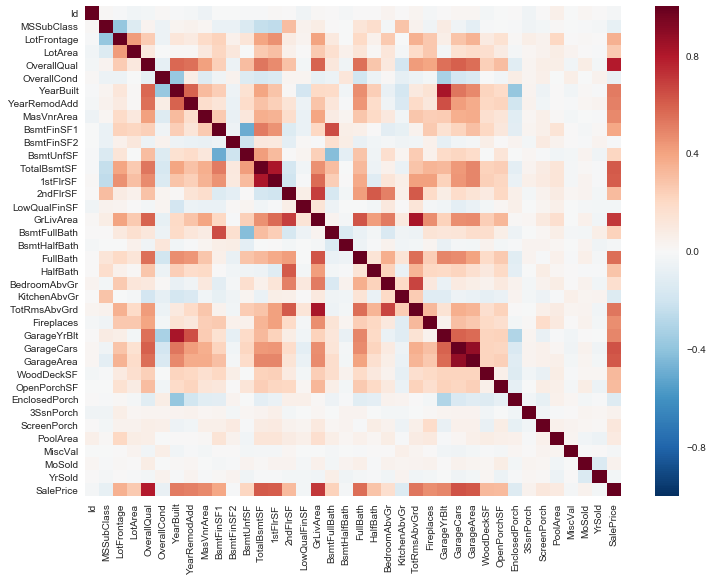

In [425]:
# Check numeric feature correlations using Heatmap
# Correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1.0, square=False);

It seems that the following numeric features are highly related to sale price:
OverallQual, TotalBsmtSF, 1stFlrSF, GrLivArea, Fullbath, TotRmsAbvGrd, GarageCars,GarageArea.
Create a zoomed heatmap to take a loser look at those vars.

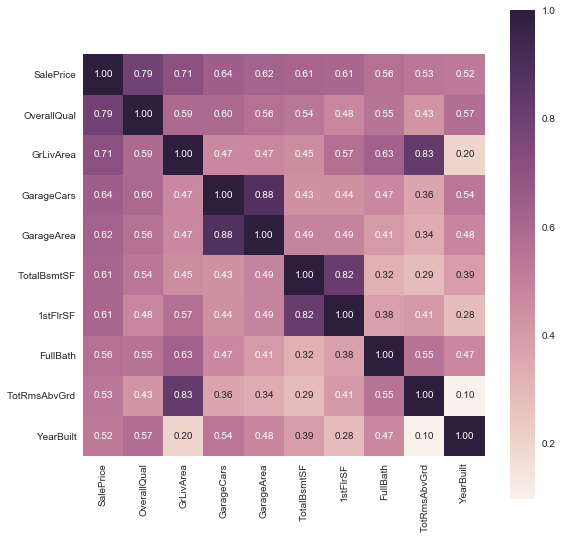

In [426]:
# Saleprice correlation matrix (zoomed heat map)
k=10
cols=corrmat['SalePrice'].nlargest(k).index
cm=np.corrcoef(train[cols].values.T)
plt.figure(figsize=(9,9))
sns.heatmap(cm,cbar=True,annot= True,square=True,fmt='.2f',annot_kws={'size':10},xticklabels=cols.values,yticklabels=cols.values)

Three pairs of features have the colinearity issue: GarageCars vs GarageArea, TotalBsmtSF vs 1stFlrSF, and GrLivArea vs TotRmsAbvGrd; Those are pretty analogous features. I would keep GarageCars, GrLivArea, and TotalBsmtSF since their correlation to SalePrice is slightly higher 

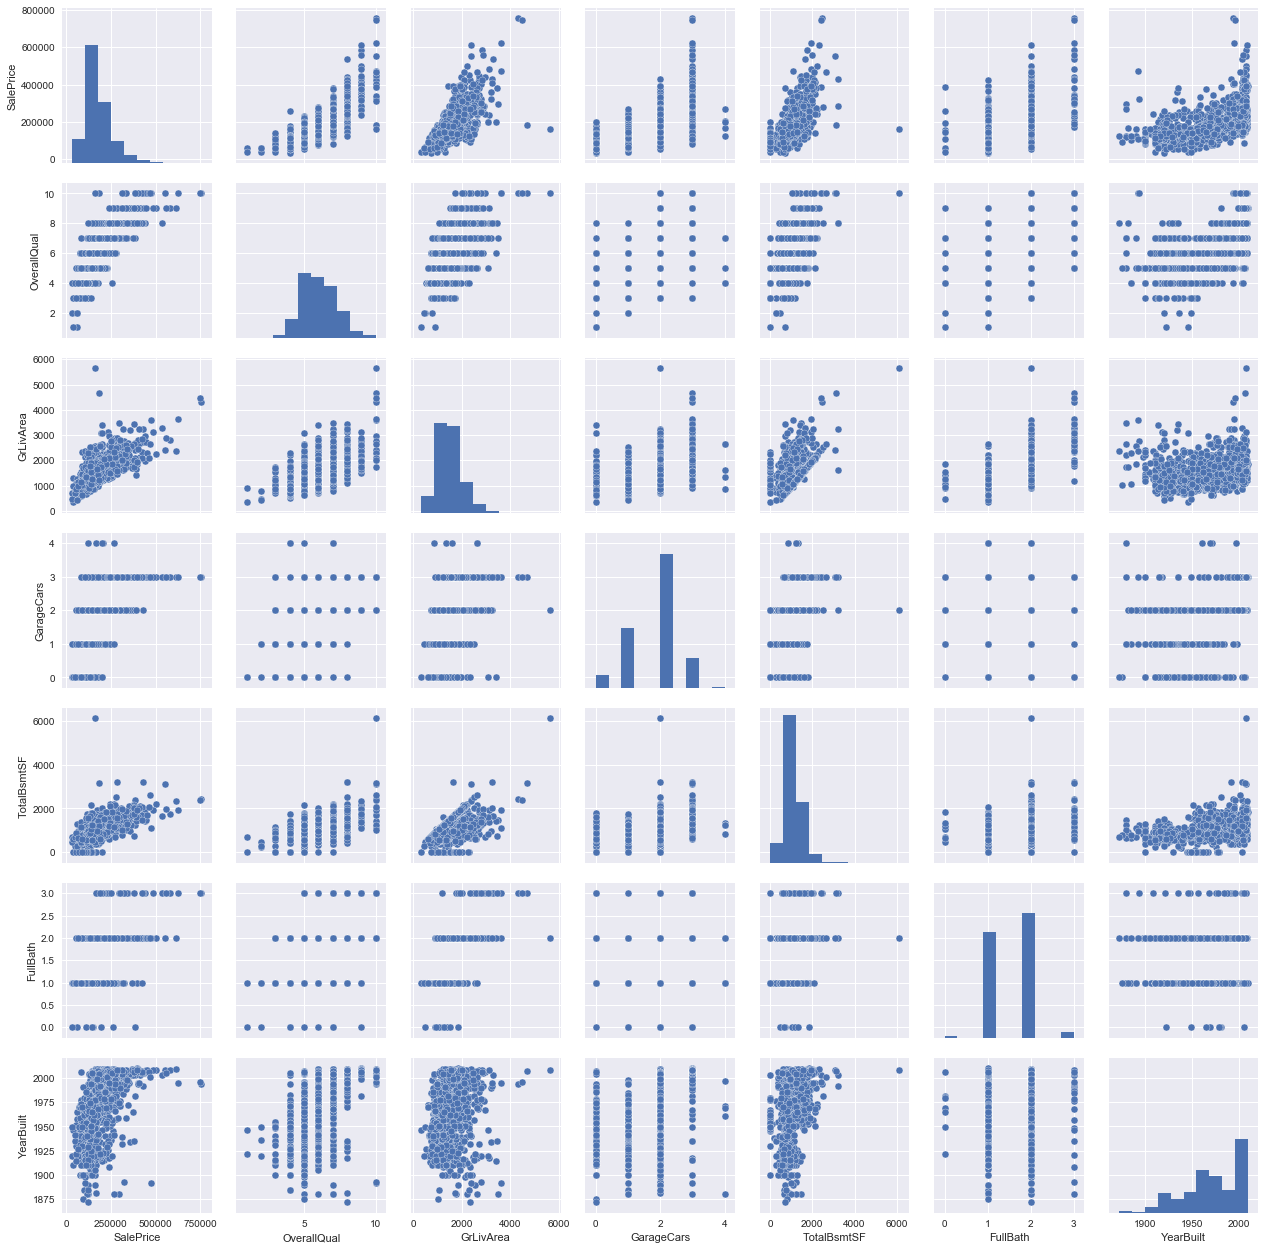

In [427]:
# Check covariants via pairplot
important_nums =["SalePrice","OverallQual","GrLivArea","GarageCars","TotalBsmtSF", "FullBath","YearBuilt"]
sns.pairplot(train[important_nums])

A couple of findings:

1) None of the features closes to normal distribution. Transformation is needed;

2) All features are positively correlated to sale price;

3) Some outliers can be found. For example, the dots representing extra large living space in both GrLivArea and TotalBsmtSF

## Check out categorical features

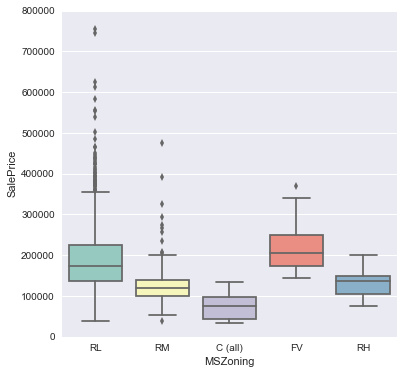

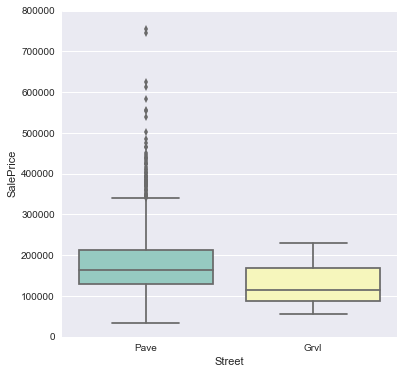

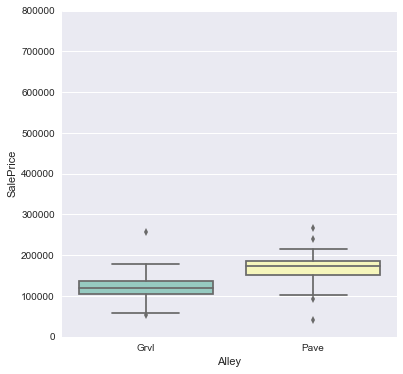

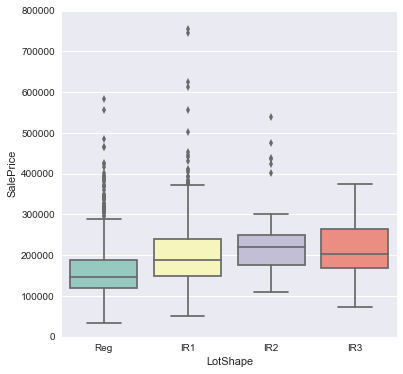

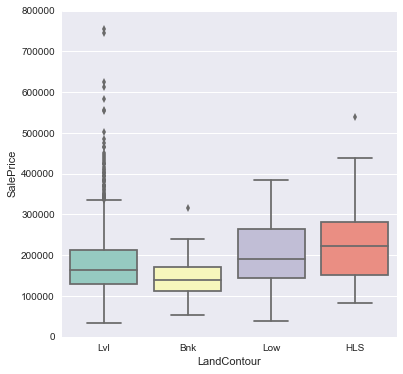

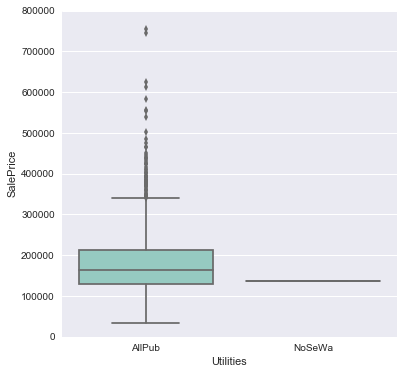

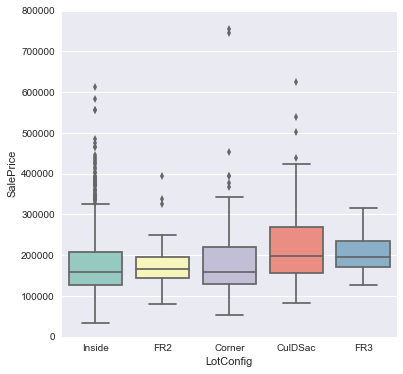

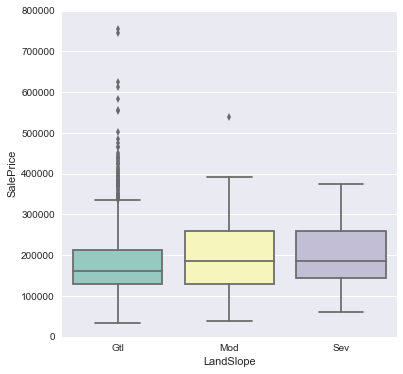

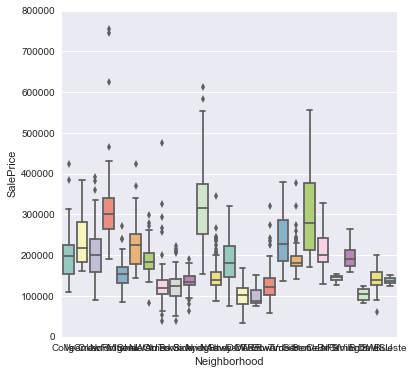

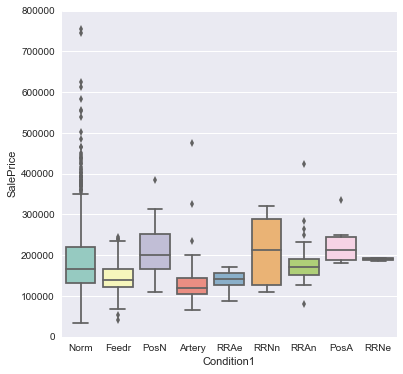

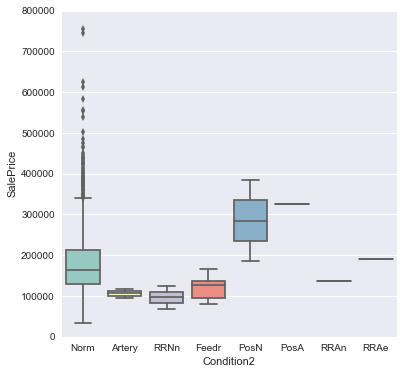

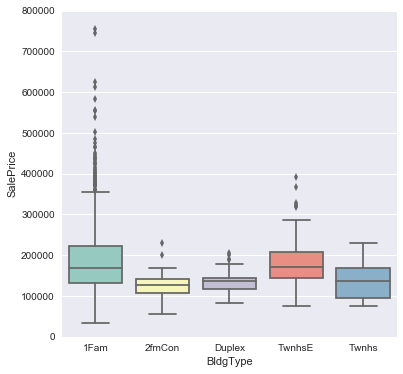

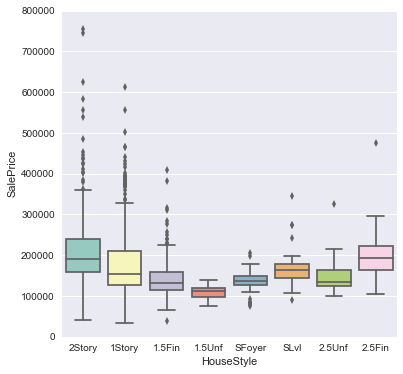

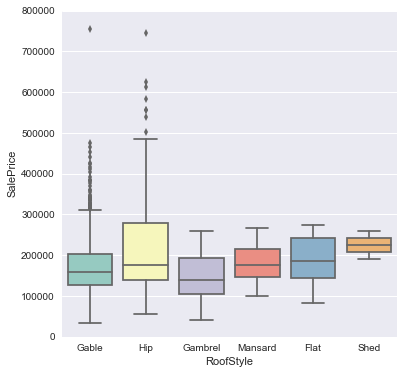

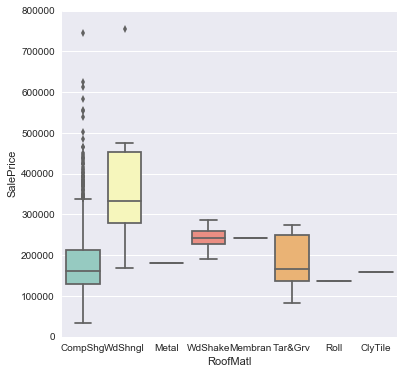

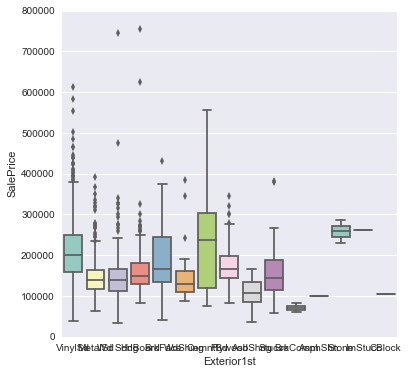

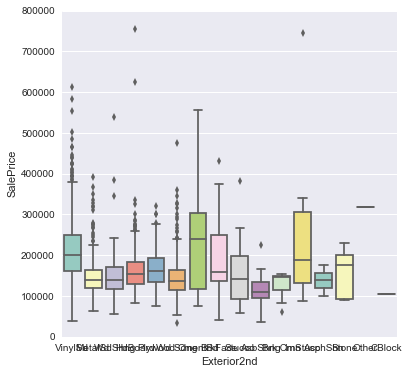

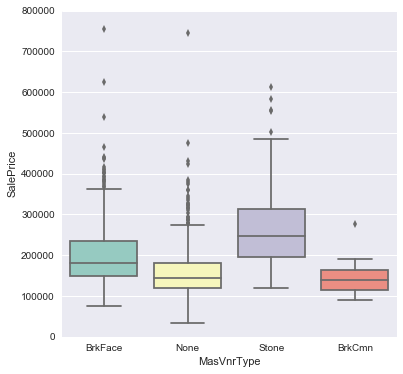

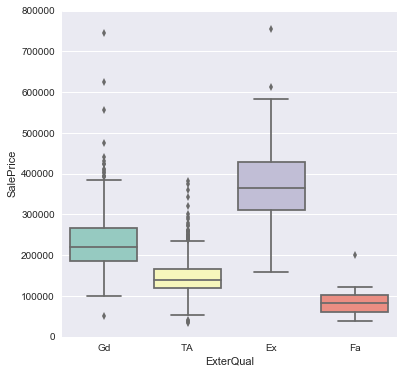

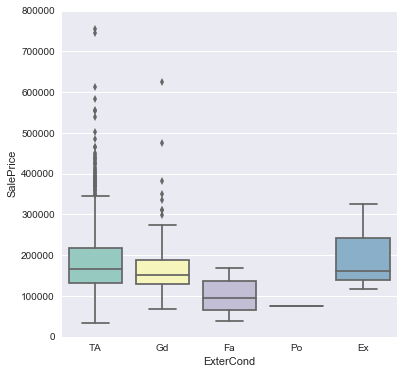

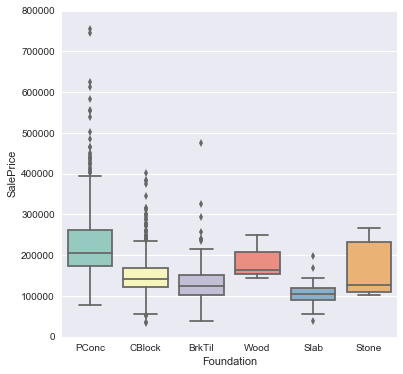

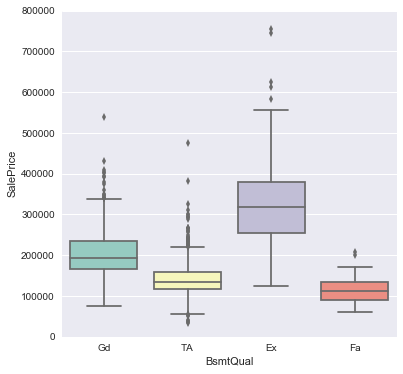

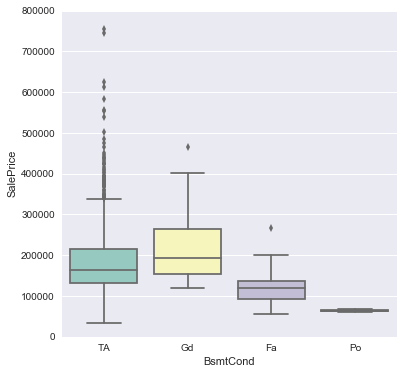

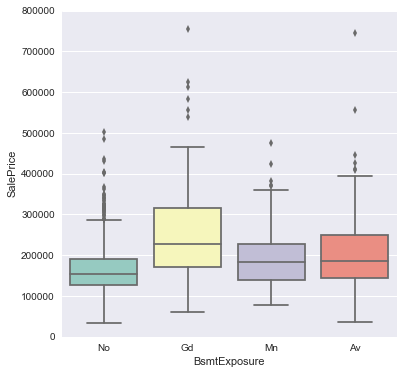

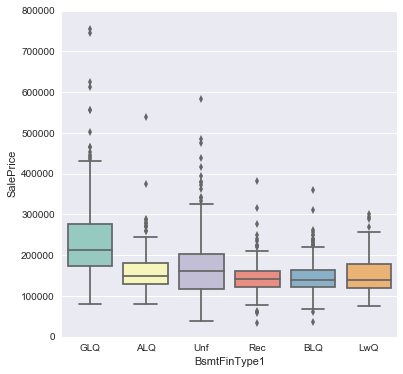

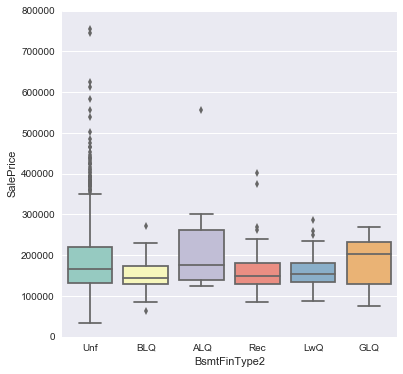

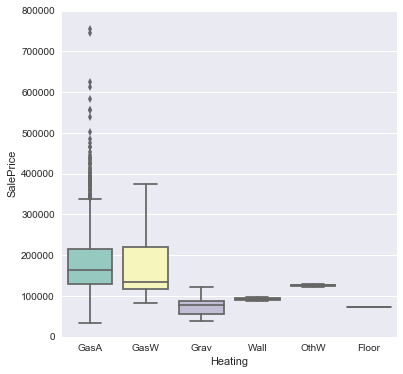

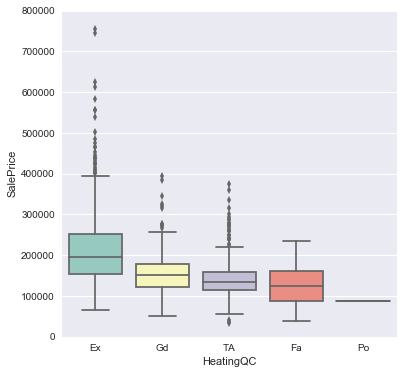

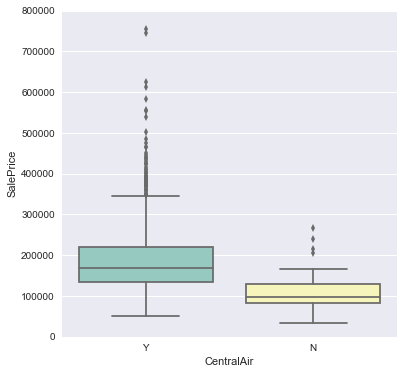

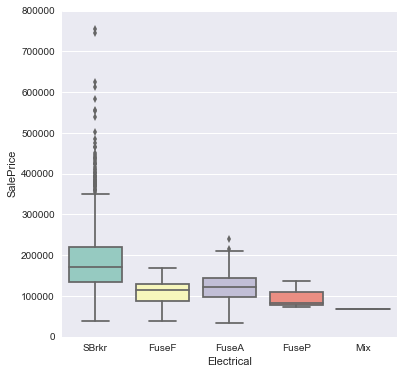

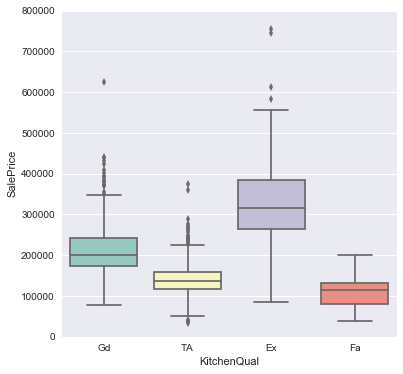

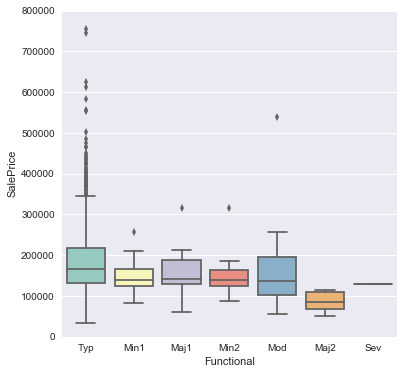

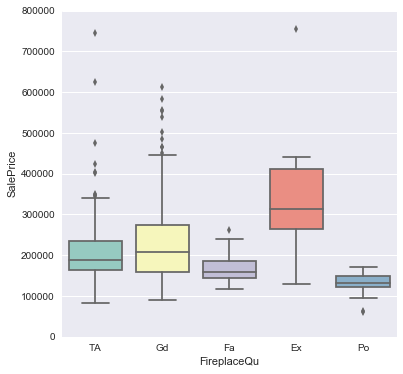

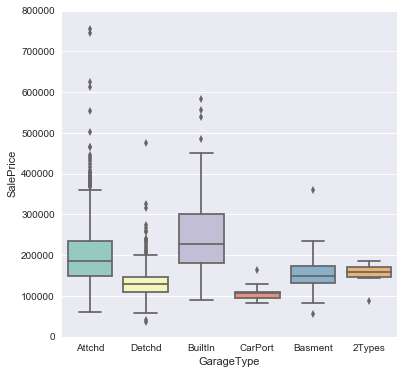

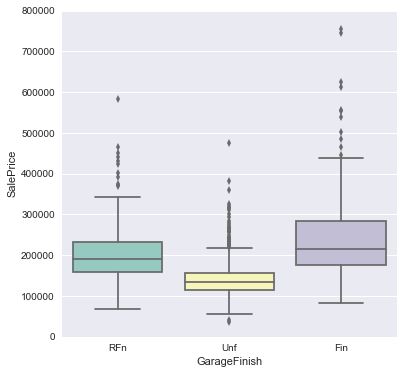

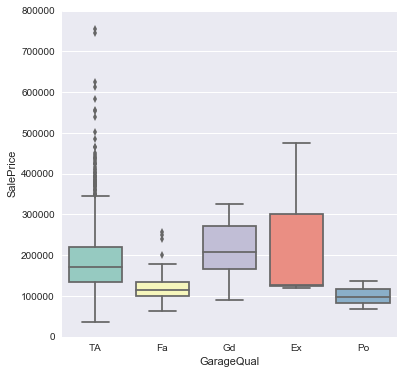

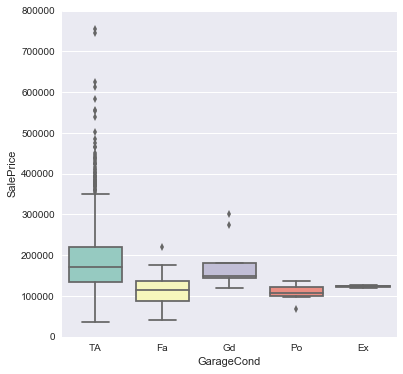

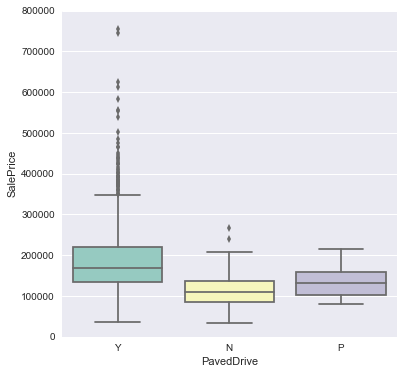

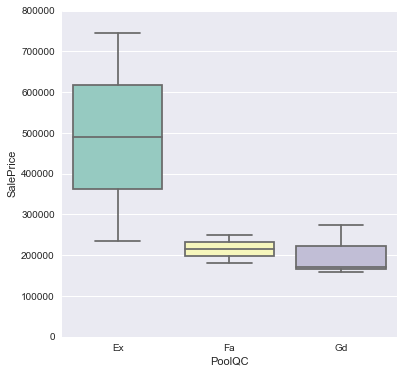

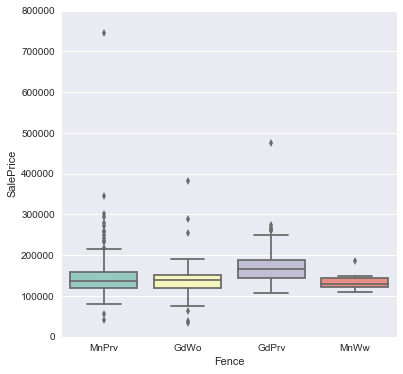

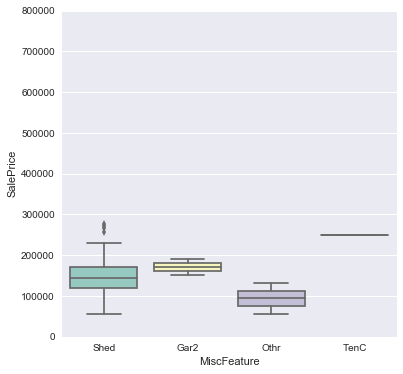

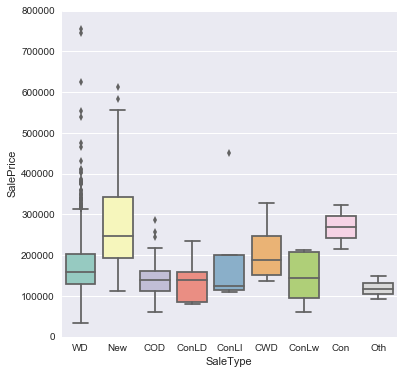

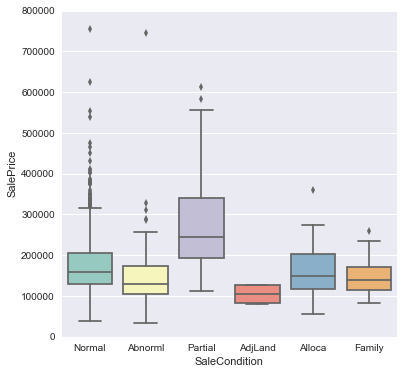

In [428]:
for feature in cat_features:
    f,ax=plt.subplots(figsize=(6,6))
    ax = sns.boxplot(x=feature, y="SalePrice",data=train,palette="Set3")
    ax.axis(ymin=0, ymax=800000)

Some categories seem to more diverse with respect to SalePrice than others.The following categorical vars are correlated to sale price, based on eyeball check on box plots:

Neighborhood, Condition1, condition2, bldgType,HouseStyle, RoofMatl, Exterior1st,Exteior2nd,ExterQual,ExterCond, Foundation,BsmtQual,BsmtCond, BsmtFinType1,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,SaleType,SaleCondition

## Remove outliers

In [429]:
# Based on eyeball test, get rid of a few outliers in the GrLivArea and TotalBsmtSF var;
print(train.GrLivArea.nlargest(5))
print(train.TotalBsmtSF.nlargest(5))
print(train.shape)
train = train.drop(train[train.Id==1298].index)
train = train.drop(train[train.Id==523].index)
print(train.shape)

1298    5642
523     4676
1182    4476
691     4316
1169    3627
Name: GrLivArea, dtype: int64
1298    6110
332     3206
496     3200
523     3138
440     3094
Name: TotalBsmtSF, dtype: int64
(1460, 81)
(1458, 81)


## Check out the label

Skewness of the label is 1.880729


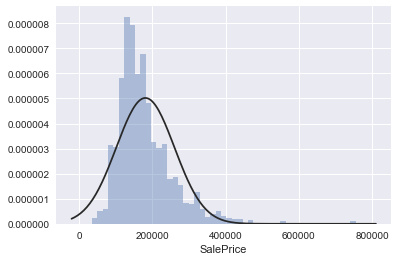

In [430]:
# The distribution of sale price deviates from the normal distribution and positively skewed
sns.distplot(train.SalePrice, fit=norm,kde = False)
print("Skewness of the label is %f" % train['SalePrice'].skew())

## Transform the label

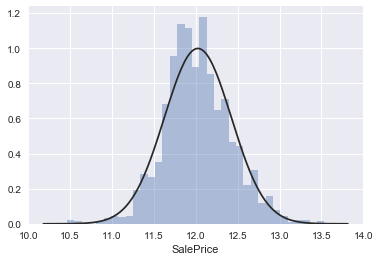

In [431]:
# Log transform the label
saleprice_transformed = np.log(train.SalePrice)
sns.distplot(saleprice_transformed,fit=norm,kde = False)
fig= plt.figure()

## Handle missing data

In [432]:
# Merge train and test df
all= pd.concat([train,test],keys=("train","test"))
all =all.drop("SalePrice",axis=1)
print(all.shape)

(2917, 80)


In [433]:
# Check missing data
total = train.isnull().sum().sort_values(ascending=False)
pct = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
NAs = pd.concat([total, pct], axis=1, keys=['Total', 'Percent'])
NAs = NAs[NAs['Total']>=1]
NAs

,Total,Percent
PoolQC,1451,0.995199
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,689,0.472565
LotFrontage,259,0.177641
GarageCond,81,0.055556
GarageType,81,0.055556
GarageYrBlt,81,0.055556
GarageFinish,81,0.055556


In [434]:
# Instead of deleting all those vars, think of ways to impute them
# Dealing with missing data
all = all.drop(NAs[NAs.Percent>0.40].index,axis=1)
print(all.shape)

(2917, 75)


In [435]:
# impute all NA numeric vars with the median
all = all.fillna(all.median())

# impute all NA categorical vars with the most likely value
all_NAs = all.isnull().sum()
all_NAs = all_NAs[all_NAs>0]
all_NAs.index

Index(['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
       'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'KitchenQual', 'MSZoning',
       'MasVnrType', 'SaleType', 'Utilities'],
      dtype='object')

In [436]:
for col in all_NAs.index:
    print(all[col].value_counts())

TA    2604
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64
No    1903
Av     418
Gd     275
Mn     239
Name: BsmtExposure, dtype: int64
Unf    851
GLQ    848
ALQ    428
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
Unf    2491
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
TA    1282
Gd    1208
Ex     258
Fa      88
Name: BsmtQual, dtype: int64
SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64
VinylSd    1024
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
Stone         2
CBlock        2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64
VinylSd    1013
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone   

In [437]:
# Impute categorical vars with the most frequent(likely) type
all.BsmtCond.fillna("TA",inplace=True)
all.BsmtExposure.fillna("No",inplace=True)
all.BsmtFinType1.fillna("Missing",inplace=True)
all.BsmtFinType2.fillna("Missing",inplace=True)
all.BsmtQual.fillna("TA",inplace=True)
all.Electrical.fillna("SBrkr",inplace=True)
all.Exterior1st.fillna("VinylSd",inplace=True)
all.Exterior2nd.fillna("VinylSd",inplace=True)
all.Functional.fillna("TA",inplace=True)
all.KitchenQual.fillna("TA",inplace=True)
all.MSZoning.fillna("RL",inplace=True)
all.SaleType.fillna("WD",inplace=True)
all.Utilities.fillna("AllPub",inplace=True)

## Transform features

In [438]:
# Differentiate numerical features and categorical features
cat_features = all.select_dtypes(include=["object"]).columns
num_features = all.select_dtypes(exclude=['object']).columns
all_num = all[num_features]
all_cat = all[cat_features]
print(all_num.shape)
print(all_cat.shape)

(2917, 37)
(2917, 38)


In [439]:
# Log transform of the skewed numerical features to lessen impact of outliers
skewed_features = all[num_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_features = skewed_features[skewed_features > 0.50]
skewed_features = skewed_features.index
print("number of skewed features is "+ str(len(skewed_features)))
all_num[skewed_features] = np.log1p(all_num[skewed_features])

number of skewed features is 26


In [440]:
# Polynomials on the most important numeric features
def quadratic(df,feature):
    df[feature+'2'] = df[feature]**2
    
def cubic(df,feature):
    df[feature+'3'] = df[feature]**3

In [441]:
cols =["OverallQual","GrLivArea","GarageCars","TotalBsmtSF", "FullBath"]
for feature in cols:
    quadratic(all_num,feature);
    cubic(all_num,feature);
all_num.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold', 'OverallQual2', 'OverallQual3', 'GrLivArea2',
       'GrLivArea3', 'GarageCars2', 'GarageCars3', 'TotalBsmtSF2',
       'TotalBsmtSF3', 'FullBath2', 'FullBath3'],
      dtype='object')

In [442]:
# Create dummy variable for categorical features
print("NAs for categorical features in train : " + str(all_cat.isnull().values.sum()))
all_cat = pd.get_dummies(all_cat)
print("Remaining NAs for categorical features in train : " + str(all_cat.isnull().values.sum()))

NAs for categorical features in train : 658
Remaining NAs for categorical features in train : 0


In [443]:
all_data = pd.concat([all_num,all_cat],axis=1)
all_data.shape

(2917, 284)

## Modelling

In [467]:
# merge categorical and numeric variables
idx = pd.IndexSlice
train_features = all_data.loc[idx[['train'],:],:]
test_features = all_data.loc[idx[['test'],:],:]
train_label = saleprice_transformed
print(train_features.shape)
print(test_features.shape)
print(len(train_label))

(1458, 284)
(1459, 284)
1458


In [468]:
# Double check no NAs in the train dataset
print(train_features.isnull().sum().max())

0


In [469]:
# Standardize the features
train_features = StandardScaler().fit_transform(train_features)
test_features = StandardScaler().fit_transform(test_features)

In [470]:
# Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_label, test_size=0.3, random_state=10)

In [471]:
# Define model evaluation function
def rmse_cv(estimator):
    rmse= np.sqrt(-cross_val_score(estimator, x_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

### Linear Regression with Ridge regularization (L2 penalty)

In [472]:
ridge = RidgeCV(alphas =[0.1,1,50,100,500,600]).fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 500.0


In [473]:
# Get a series of alphas centering around the best alpha
def get_params(center_params):
    new_params=[]
    for m in np.arange(0.8,1.2,0.05):
        new_params.append(round(center_params*m,4))
    return new_params

In [474]:
new_alphas = get_params(alpha)
print(new_alphas)
ridge = RidgeCV(alphas = new_alphas).fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

[400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0]
Best alpha : 525.0


In [475]:
print("RMSE : ", rmse_cv(ridge).mean())

RMSE :  0.135919201104


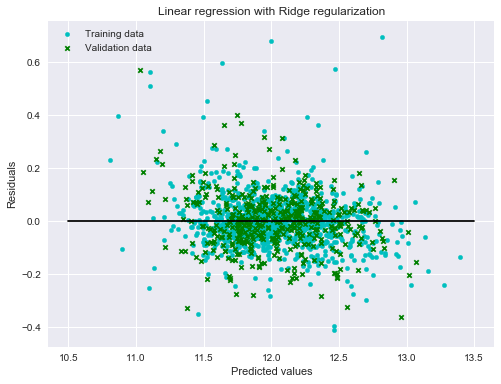

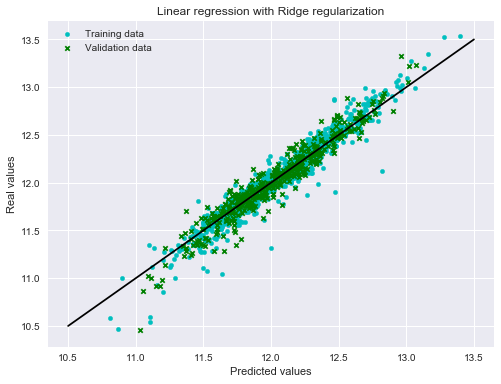

In [476]:
y_train_pred = ridge.predict(x_train)
y_test_pred = ridge.predict(x_test)

# Plot residence
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train_pred - y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.plot([10.5,13.5],[0,0], color = "k")
plt.show()

# Plot predictions
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "k")
plt.show()

### Linear Regression with Lasso regularization (L1 penalty)

In [477]:
# Fit Lasso model
lasso = LassoCV(alphas =[0.001,0.005,0.01,0.05,0.1,1]).fit(x_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.005


In [478]:
new_alphas = get_params(alpha)
print(new_alphas)
ridge = RidgeCV(alphas = new_alphas).fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

[0.0040000000000000001, 0.0041999999999999997, 0.0044999999999999997, 0.0047999999999999996, 0.0050000000000000001, 0.0053, 0.0054999999999999997, 0.0057999999999999996]
Best alpha : 0.0058


In [479]:
print("RMSE : ", rmse_cv(lasso).mean())

RMSE :  0.134287028907


Lasso model: 92 features are picked and 192 features are dropped


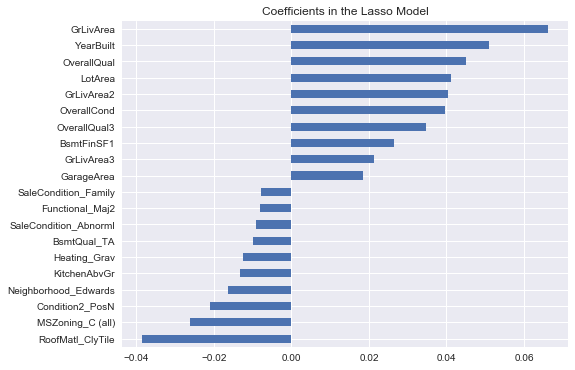

In [480]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_,index=all_data.columns)
print("Lasso model: " + str(sum(coefs != 0))+" features are picked and " + str(sum(coefs == 0))+" features are dropped")
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model")

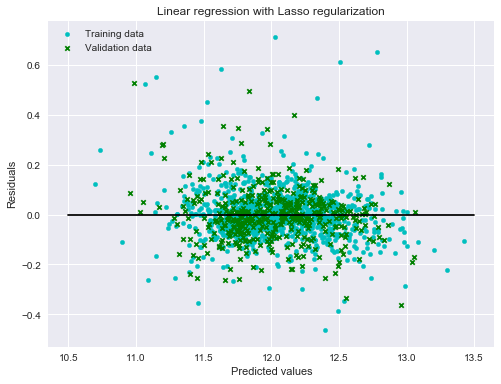

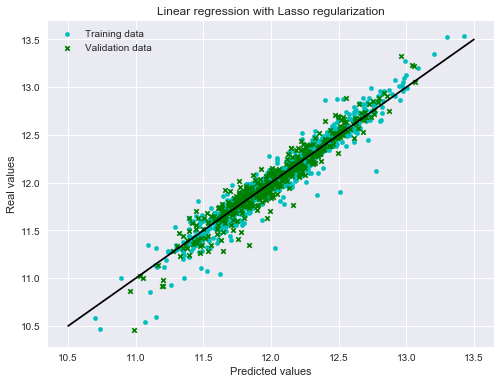

In [481]:
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

# Plot residence
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train_pred - y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.plot([10.5,13.5],[0,0], color = "k")
plt.show()

# Plot predictions
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "k")
plt.show()

### Elastic Net Model (L1 and L2 penalty)

Elastic Net is a compromise between Ridge and Lasso regression. It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso, such as the number of variables (Lasso can't select more features than it has observations, but it's not the case here anyway).

In [482]:
enet = ElasticNetCV(alphas=[0.001,0.005,0.01,0.05,0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99]).fit(x_train, y_train)
alpha = enet.alpha_
l1_ratio = enet.l1_ratio_
print("Best alpha :", alpha)
print("Best L1 ratio :", l1_ratio)

Best alpha : 0.05
Best L1 ratio : 0.1


In [483]:
new_alphas = get_params(alpha)
new_l1_ratios = get_params(l1_ratio)
print(new_alphas)
print(new_l1_ratios)

[0.040000000000000001, 0.042500000000000003, 0.044999999999999998, 0.047500000000000001, 0.050000000000000003, 0.052499999999999998, 0.055, 0.057500000000000002]
[0.080000000000000002, 0.085000000000000006, 0.089999999999999997, 0.095000000000000001, 0.10000000000000001, 0.105, 0.11, 0.115]


In [484]:
# Try out the best L1 ratio first
enet = ElasticNetCV(alphas=[0.001,0.005,0.01,0.05,0.1, 1, 10], l1_ratio=new_l1_ratios).fit(x_train, y_train)
l1_ratio = enet.l1_ratio_
print("Best L1 ratio :", l1_ratio)

# Try out the best alpha based on the fixed best l1 ratio 
enet = ElasticNetCV(alphas=new_alphas, l1_ratio=l1_ratio).fit(x_train, y_train)
alpha = enet.alpha_
l1_ratio = enet.l1_ratio_
print("Best alpha :", alpha)
print("Best L1 ratio :", l1_ratio)

Best L1 ratio : 0.095
Best alpha : 0.0525
Best L1 ratio : 0.095


In [485]:
print("RMSE : ", rmse_cv(enet).mean())

RMSE :  0.133131223855


Lasso model: 96 features are picked and 188 features are dropped


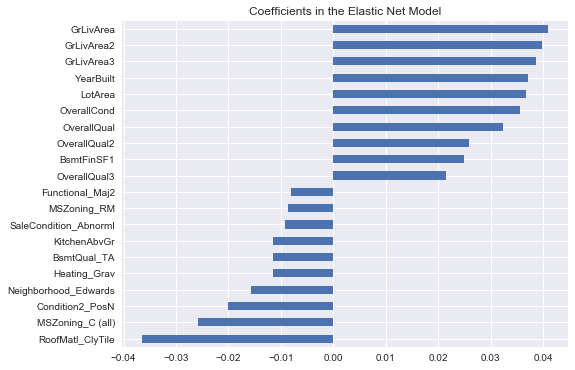

In [486]:
# Plot important coefficients
coefs = pd.Series(enet.coef_,index=all_data.columns)
print("Lasso model: " + str(sum(coefs != 0))+" features are picked and " + str(sum(coefs == 0))+" features are dropped")
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Elastic Net Model")

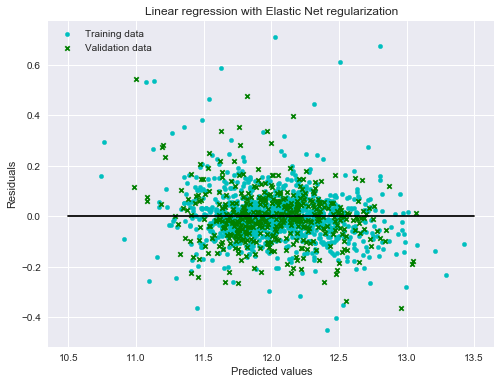

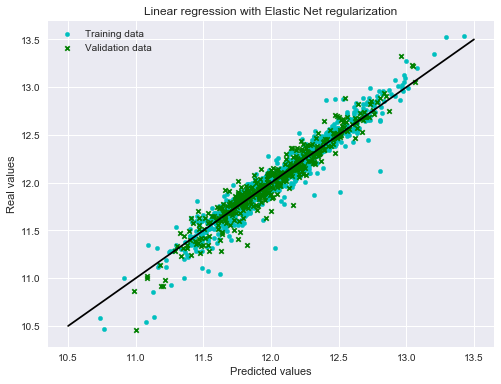

In [487]:
y_train_pred = enet.predict(x_train)
y_test_pred = enet.predict(x_test)

# Plot residence
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train_pred - y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Elastic Net regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.plot([10.5,13.5],[0,0], color = "k")
plt.show()

# Plot predictions
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Elastic Net regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "k")
plt.show()

## Predict the test label

In [489]:
## Getting the final SalePrice estimation
ridge_model = ridge.fit(x_train,y_train)
enet_model = enet.fit(x_train,y_train)
final_labels = 0.3*np.exp(ridge_model.predict(test_features)) + 0.7*np.exp(enet_model.predict(test_features))

## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': final_labels}).to_csv('2017_6_25.csv', index =False) 